In [1]:
import os
import string
import sys
import time
from numpy import *
from scipy.constants import c as clight
from scipy.constants import e as qe
from scipy.constants import m_p
from scipy.constants import epsilon_0 as eps0
from scipy.fftpack import fft,ifft,fftfreq
import scipy.optimize
from numpy.random import random_sample, normal
from pylab import *
import pickle
from time import time
from statsmodels.nonparametric.kernel_regression import KernelReg
from scipy.stats import norm

In [2]:
import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})

In [3]:
# ideal beam particle
class Ideal_Particle:
    def __init__(self,s,gamma0,gammat,Z,A):
        self.s=s
        self.gamma0=gamma0
        self.gammat=gammat
        self.Z=Z
        self.A=A

In [4]:
Particle0=Ideal_Particle(0.0,2.0,10.0,1.0,1.0) # 1 GeV Proton

In [5]:
# map for all particles
class SectorMap:

    def __init__(self, name, keyword, length):
        self.name=name
        self.keyword=keyword
        self.L=length
        self.M=array([[1.0,0.0],[0.0,1.0]])

    def from_matrix(self,M):
        self.M=M

    def oneturn(self,eta0):
        self.M[0,1]=-eta0*self.L

    def get_M(self):
        return self.M

In [6]:
# A container list for SectorMap Elements:

BeamLine=[]

In [7]:
# empty beamline

def clear_bline():
    BeamLine[:]=[]

# most simple beamline:

In [8]:
def constant_focusing(s1,s2,eta0):
    SM=SectorMap('simple','simple',s2-s1)
    SM.oneturn(eta0)
    BeamLine.append(SM)
    
# beam transport
def transport(r2d_vec,M):
    N_p=r2d_vec.shape[0]
    return array([dot(M,r2d_vec[j]) for j in range(N_p)])

def periodic_boundaries(r2d_vec,length):
    N_p=r2d_vec.shape[0]
    for j in range(N_p):
        z=r2d_vec[j,0]
        if z < -0.5*length:
            r2d_vec[j,0]=length + z
        if z > 0.5*length:
            r2d_vec[j,0]=z - length
            
# init longitudinal: dc beam
def init_coasting_beam(Np,sigma_p,length):
    r2d_vec=zeros((Np,2))
    r2d_vec[:,1]=sigma_p*normal(0.0, 1.0, Np)
    r2d_vec[:,0]=length*random_sample(Np)-0.5*length
    return r2d_vec

# line density (with periodic bc)
def density_z(r2d_vec,ldy,charge,dz):
    NZ=ldy.shape[0]-1
    N_p=r2d_vec.shape[0]
    for j0 in range(N_p):
        dist0=r2d_vec[j0,0]+0.5*NZ*dz
        j1=int(dist0/dz)
        j2=j1+1
        f1=(j2*dz-dist0)/dz
        f2=(dist0-j1*dz)/dz
        ldy[j1] += charge*f1/(NZ*dz)
        ldy[j2] += charge*f2/(NZ*dz)
    # periodic boundary conditions
    ldy[0]+=ldy[NZ]
    ldy[NZ]=ldy[0]

def run_lobo(NT,Np,NZ,charge,sigma_p,length,eta0):
    constant_focusing(0.0,length,eta0)
    r2d_vec=init_coasting_beam(Np,sigma_p,length)
    ldy_arr=zeros((NT,NZ+1))
    dz=length/NZ
    for j in range(NT):
        r2d_vec=transport(r2d_vec,BeamLine[0].get_M())
        periodic_boundaries(r2d_vec,length)
        Particle0.s+=length
        density_z(r2d_vec,ldy_arr[j,:],charge,dz)
        # space charge impedance kick should be here
    return ldy_arr

# transform waterfall ldy_arr into Schottky spectrum
def Schottky(ldy_arr):
    NT=ldy_arr.shape[0]
    NZ=ldy_arr.shape[1]-1
    ldy_vec=zeros(NT*NZ)
    for j in range(NT):
        for k in range(NZ):
            ldy_vec[j*NZ + k]=ldy_arr[j,k]
    ldy_fft=fft(ldy_vec)
    return ldy_fft

#gaussian function used for curve fitting
def gaussian(x, amp, mu, sigma2):
    return amp*np.exp(-((x-mu)**2)/(2*sigma2))

In [9]:
class Simul_data:
    def __init__(self, Nt,e_kin,sigma_p,f0,harmonic,ldy_fft):
        self.Nt = Nt
        self.e_kin = e_kin
        self.sigma_p = sigma_p
        self.data = ldy_fft
        self.f0 = f0
        self.harmonic = harmonic

class Train_log:
    def __init__(self, data_mean, data_var):
        self.data_mean = data_mean
        self.data_var = data_var

def Cleaner(data, data_mean, data_var):
    epsilon = 0.01
    data_clean = (data - data_mean)/(data_var+epsilon)
    return data_clean

def unCleaner(data,data_mean,data_var):
    epsilon = 0.01
    data_restore = (data*(data_var + epsilon)) + data_mean
    return data_restore

def f0_from_ekin(e_kin,circum):
    gamma0 = 1.0+(e_kin*1e6*qe)/(m_p*clight*clight)
    beta0 = sqrt((gamma0*gamma0-1.0)/(gamma0*gamma0))
    f0 = beta0*clight/circum
    return f0

def Center_data(data,f0,f0_mean,harmonic,Nturns,Npoints,delta):
    data_size = data.shape[0]
    data_centered = zeros([data_size,2*delta])
    for count in range(data_size):     #not the cleanest thing, improve later
        rho = f0_mean/f0[count]
        Ncenter_float = (1-rho)*harmonic*Nturns + Npoints/2
        Ncenter = int(Ncenter_float.round())
        data_inst = data[count,:]
        data_centered[count,:] = data_inst[(Ncenter - delta):(Ncenter + delta)]
    return data_centered

In [10]:
Nensemble = 1#int(2e3)                    #number of training exemples
Nvalidate = int(2e3)                    #number of validating exemples
Nturns = int(2**10)
alpha_length = 0.4
Nfreqlength = int(alpha_length*Nturns)  #number of points in frequency of a training exemple
circum = 216.0                          #circumference of the accelerator


simmulation_name = 'pyLOBO.py'  #mame of the python script that generates the data
data_file_name = 'Simulated Data/test_val2.dat'  #name of the file which stores the results of the simulations for training
validate_data_file_name = 'Simulated Data/data_2to10_validate_w_f02.dat' #name of the file which stores the results of the simulations for validation
regressor_file = 'regressor.dat'   #name of the file which stores the values of the regressor

#metaparameters of the simulation

ekin_lowerbound = 10.4 #mean of the generetor of the initial Kinetic Energy (to be exponentiated)
ekin_higherbound = 12.4 #spread of the generetor of the initial Kinetic Energy (to be exponentiated)
ekin_mean = 11.4
ekin_span = 2

sigmap_lowerbound = 0.5e-3 #mean of the generator of the initial Momentum Spread
sigmap_higherbound = 1.5e-3#spread of the generator of the initial Momentum Spread
sigmap_mean = 1e-3
sigmap_span = 1e-3

f0_min = training_classes.f0_from_ekin(ekin_lowerbound,circum)
f0_max = training_classes.f0_from_ekin(ekin_higherbound,circum)
f0_mean = training_classes.f0_from_ekin(ekin_mean,circum)


In [11]:
    for j in range(Nensemble):
                
        # turns
        circum=216.0
        # init beam parameter
        sigma_p= (sigmap_higherbound - sigmap_lowerbound)*random_sample() + sigmap_lowerbound
        Ni=1.0e10
        e_kin= 11.4 #(trainer.ekin_higherbound - trainer.ekin_lowerbound)*random_sample() + trainer.ekin_lowerbound   # MeV/u
        gamma0=1.0+(e_kin*1e6*qe)/(m_p*clight*clight)
        beta0=sqrt((gamma0*gamma0-1.0)/(gamma0*gamma0))
        Particle0.gamma0=gamma0
        Particle0.gammat=5.4
        Particle0.Z=18.0
        Particle0.A=40.0
        eta0=-1.0 # 1.0/Particle0.gammat**2-1.0/gamma0**2
        # macro particle number and charge
        Np=1024
        charge=Particle0.Z*Ni/Np
        NZ=128
        # run
        ldy_arr=run_lobo(Nturns,Np,NZ,charge,sigma_p,circum,eta0)

        ldy_fft=Schottky(ldy_arr)


    
        # plot Schottky power spectrum
        f0=beta0*clight/circum
        dz=circum/NZ
        dt=dz/(beta0*clight)
        #print ("f0:",f0)
        freq=fftfreq(Nturns*NZ,d=dt)
        #plot(freq,absolute(ldy_fft))

        #Save emsemble data
        harmonic=30
        Ncenter = int(harmonic*f0_mean/freq[1])
        Delta_F = trainer.Nfreqlength
        Nfreqlow = Ncenter - Delta_F
        Nfreqhigh = Ncenter + Delta_F
        
        n = list(freq/f0)
        f1 = n.index(harmonic - .5)#6.9033203125)
        f2 = n.index(harmonic + .5)#7.0947265625)
        data = absolute(ldy_fft[f1:f2])
        
        Simdat = Simul_data(Nturns,e_kin,sigma_p,f0,harmonic,data)
        #pickle.dump(Simdat,test_data)
    

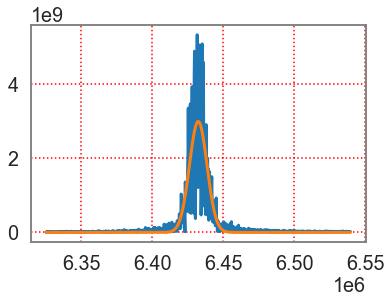

In [12]:
harmonic= 30
f0=beta0*clight/circum
f_vec=linspace((harmonic - .5)*f0,(harmonic + .5)*f0,len(data))
plot(f_vec,data)
plot(f_vec,3.0e9*exp(-(f_vec-harmonic*f0)**2/(2.0*sigma_p*harmonic*f0)**2))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))


# Simple Gaussian fitting due to very noisy data -> fails without initial guess

In [13]:
from scipy import optimize

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)

In [14]:
popt, _ = optimize.curve_fit(gaussian, f_vec, data)
print(popt)

[1. 1. 1.]


/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [15]:
initial = np.asarray([1e9,harmonic*f0,sigma_p*harmonic*f0])
popt, _ = optimize.curve_fit(gaussian, f_vec, data, p0=initial)
print(popt)

[2.72959589e+09 6.43184164e+06 2.13455693e+03]


Text(0, 0.5, 'Amplitude')

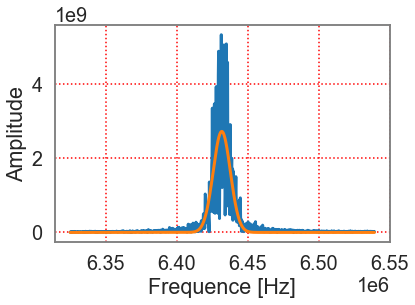

In [16]:
plt.plot(f_vec, data)
plt.plot(f_vec, gaussian(f_vec, *popt))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel('Frequence [Hz]')
plt.ylabel('Amplitude')

# KernelReg fitting due to very noisy data -> works


In [17]:
from sklearn import preprocessing
from sklearn.preprocessing import robust_scale
X_scaled = robust_scale(data)

In [18]:
mean, std = X_scaled.mean(axis=0), X_scaled.std(axis=0)
print(mean, std)

3.6030476766418476 12.011940238209524


In [19]:
kr = KernelReg(X_scaled, f_vec,'c')
y_pred, y_std = kr.fit(f_vec)

In [20]:
mu, std = norm.fit(X_scaled)

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


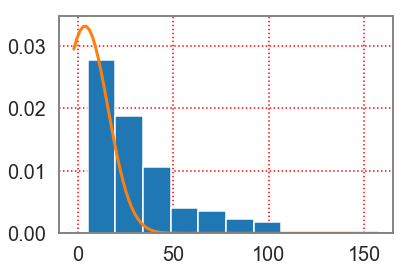

In [21]:
plt.hist(X_scaled, bins=10, normed=True, range=(5,150))
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y)


In [22]:
initial = np.asarray([max(y_pred),harmonic*f0,sigma_p*harmonic*f0])
popt, _ = optimize.curve_fit(gaussian, f_vec, X_scaled, p0=initial)

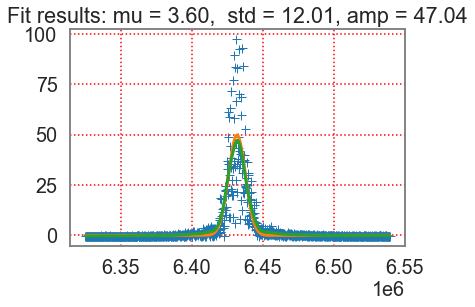

In [23]:
plt.plot(f_vec, X_scaled, '+')
plt.plot(f_vec, gaussian(f_vec, *popt))
plt.plot(f_vec, y_pred)
title = "Fit results: mu = %.2f,  std = %.2f, amp = %.2f" % (mu, std, max(y_pred))
plt.title(title)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))


(6410000.0, 6460000.0)

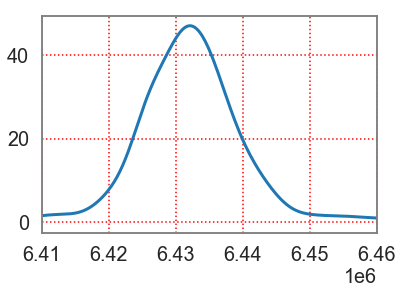

In [24]:
plt.plot(f_vec, y_pred)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
xlim(6.41e6,6.46e6)

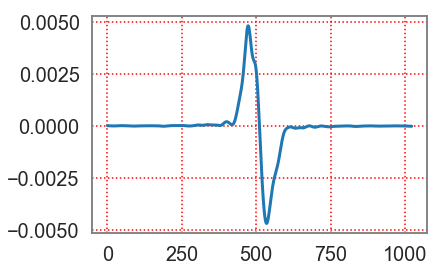

In [25]:
plot(y_std)